## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
import copy
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRicoMulti.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.
mie_mono_tables = OrderedDict()
for wavelength in [.66, 1.240, 1.640, 2.13]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

#make extinction the density instead of lwc
solvers[.66].medium['cloud'].attrs["density_name"] = "extinction"
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"density" : 'lwc'})
solvers[.66].medium['cloud'] = solvers[.66].medium['cloud'].rename_vars({"extinction" : 'density'})
data = copy.deepcopy(solvers[.66].medium['cloud'])
data['density'].data = carved_volume.mask.data.astype(float)*0
data['reff'].data = carved_volume.mask.data.astype(float)*0+10

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, data
)


In [6]:
%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)
solvers_reconstruct = at3d.containers.SolversDict()

In [7]:
# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
def train_density(density):
    # add an uncertainty model to the observations.
    uncertainty = at3d.uncertainties.NullUncertainty('L2',1e9)
    #at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    sensors.add_uncertainty_model('MSPI', uncertainty)
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
        )
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = density
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    x0 = state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction)

    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

    optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
    warnings.filterwarnings('ignore')
    optimizer._options['maxiter'] = 5
    result = optimizer.minimize(x0)
    grid_to_optical_properties._fixed_dataset['density'].data = solvers_reconstruct[0.66].medium['cloud'].density.data


In [8]:
# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
def train_reff(reff):
    # add an uncertainty model to the observations.
    uncertainty = at3d.uncertainties.NullUncertainty('L2',1e12)
    #at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    sensors.add_uncertainty_model('MSPI', uncertainty)
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data))
        )
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_reff = reff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)

    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)

    optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
    warnings.filterwarnings('ignore')
    optimizer._options['maxiter'] = 5
    result = optimizer.minimize(x0)
    grid_to_optical_properties._fixed_dataset['reff'].data = solvers_reconstruct[0.66].medium['cloud'].reff.data

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -3.973  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
     1  -3.328  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     1  -4.857  0.821E-07    31968     9.00  0.035   [Radiance 2.130 micron]
 ! Iterations:      1     Final Criterion:  0.000014   [Radiance 2.130 micron]
     2  -7.327  0.628E-06    31968     9.00  0.035   [Radiance 1.640 micron]
 ! Iterations:      2     Final Criterion:  0.000000   [Radiance 1.640 micron]
     2  -6.284  0.131E-05    31968     9.00  0.035   [Radiance 1.240 micron]
 ! Iterations:      2     Final Criterion:  0.000001   [Radiance 1.240 micron]
     

<Figure size 640x480 with 0 Axes>

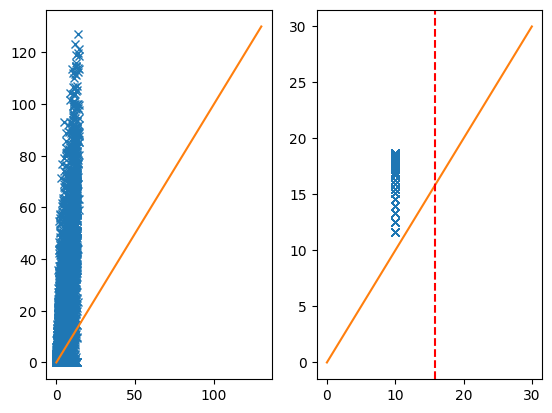

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.666  0.992E-01    31968    70.00  0.273   [Radiance 0.660 micron]
     1  -0.664  0.115E+00    31968    70.00  0.273   [Radiance 1.240 micron]
     1  -0.648  0.125E+00    31968    70.00  0.273   [Radiance 1.640 micron]
     1  -0.632  0.137E+00    31968    70.00  0.273   [Radiance 2.130 micron]
     2  -1.207  0.124E+00    31968    70.00  0.273   [Radiance 1.240 micron]
     2  -1.229  0.106E+00    31968    70.00  0.273   [Radiance 0.660 micron]
     2  -1.104  0.150E+00    31968    70.00  0.273   [Radiance 2.130 micron]
     2  -1.153  0.136E+00    31968    70.00  0.273   [Radiance 1.640 micron]
     3  -1.734  0.124E+00    31968    70.00  0.273   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

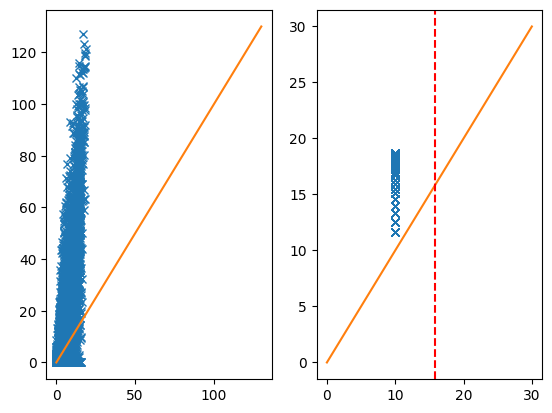

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.672  0.150E+00    31968    67.58  0.264   [Radiance 0.660 micron]
     1  -0.657  0.184E+00    31968    67.58  0.264   [Radiance 1.640 micron]
     1  -0.640  0.197E+00    31968    67.58  0.264   [Radiance 2.130 micron]
     1  -0.671  0.172E+00    31968    67.58  0.264   [Radiance 1.240 micron]
     2  -1.215  0.155E+00    31968    67.58  0.264   [Radiance 0.660 micron]
     2  -1.140  0.195E+00    31968    67.58  0.264   [Radiance 1.640 micron]
     2  -1.084  0.214E+00    31968    67.58  0.264   [Radiance 2.130 micron]
     2  -1.198  0.179E+00    31968    67.58  0.264   [Radiance 1.240 micron]
     3  -1.709  0.153E+00    31968    67.58  0.264   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

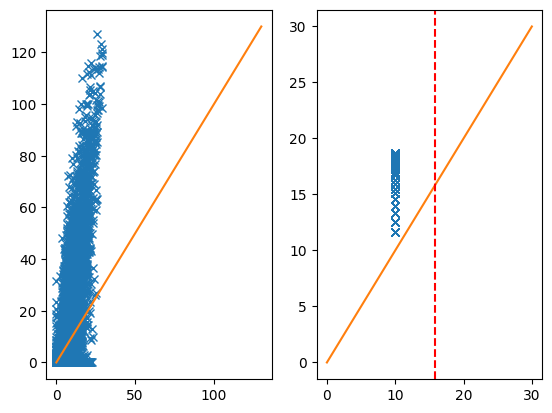

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.666  0.243E+00    31968    62.10  0.243   [Radiance 1.640 micron]
     1  -0.681  0.231E+00    31968    62.10  0.243   [Radiance 1.240 micron]
     1  -0.648  0.251E+00    31968    62.10  0.243   [Radiance 2.130 micron]
     1  -0.681  0.206E+00    31968    62.10  0.243   [Radiance 0.660 micron]
     2  -1.072  0.284E+00    31968    62.10  0.243   [Radiance 2.130 micron]
     2  -1.139  0.268E+00    31968    62.10  0.243   [Radiance 1.640 micron]
     2  -1.206  0.251E+00    31968    62.10  0.243   [Radiance 1.240 micron]
     2  -1.220  0.221E+00    31968    62.10  0.243   [Radiance 0.660 micron]
     3  -1.540  0.291E+00    31968    62.10  0.243   [Radiance 2.130 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

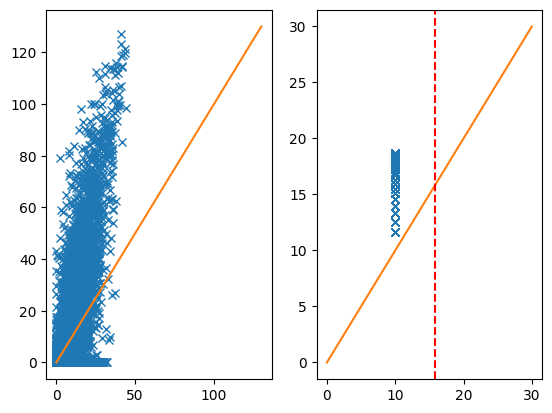

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.679  0.234E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.678  0.260E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.661  0.272E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.638  0.279E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.252E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.134  0.294E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.208  0.277E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.058  0.310E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     3  -1.557  0.295E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

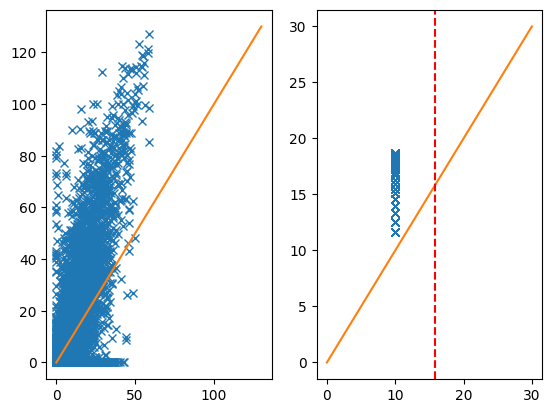


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7935      5      6   1384     0   776   2.652D+00   2.450D+04
  F =   24496.577361391908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.679  0.234E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.678  0.260E+00    31968    59.50  0.232

<Figure size 640x480 with 0 Axes>

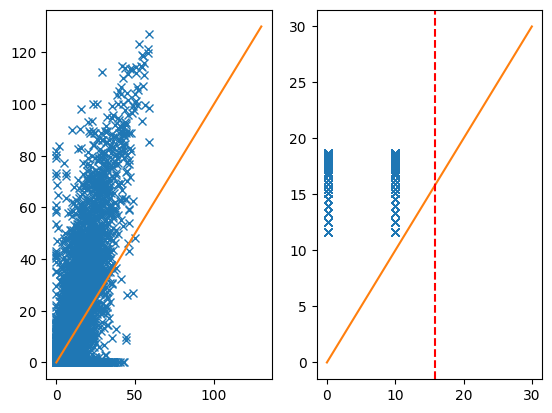

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.679  0.234E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.661  0.272E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.678  0.260E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.638  0.279E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.252E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.134  0.294E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.208  0.277E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.058  0.310E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     3  -1.650  0.254E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

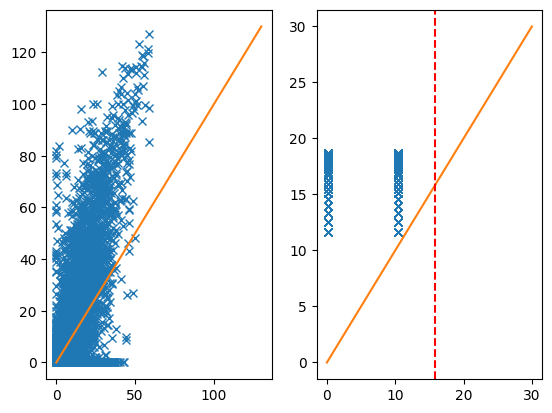

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.231E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.678  0.255E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.661  0.266E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.637  0.270E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.250E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.209  0.271E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.059  0.300E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.136  0.287E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     3  -1.653  0.252E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.675  0.212E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.662  0.215E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.675  0.220E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.647  0.198E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.223  0.232E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.103  0.217E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.154  0.233E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.216  0.240E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     3  -1.671  0.233E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

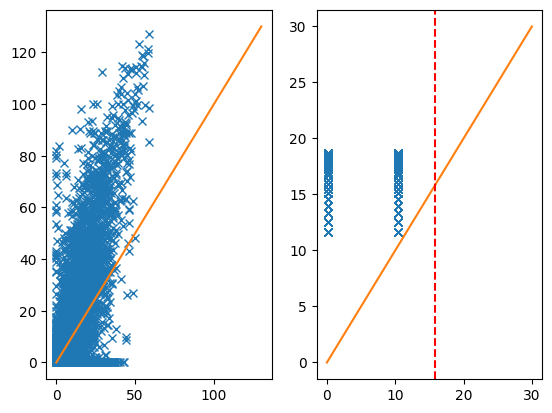

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.233E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.678  0.258E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.661  0.269E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.638  0.275E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.251E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.209  0.275E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.059  0.306E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.135  0.291E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     3  -1.652  0.253E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

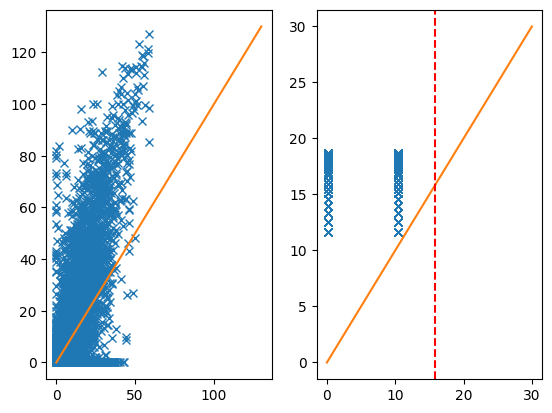

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.678  0.232E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.661  0.268E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.678  0.258E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.638  0.274E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.251E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.135  0.290E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.209  0.274E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.059  0.305E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     3  -1.652  0.253E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.675  0.212E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.675  0.220E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     1  -0.662  0.215E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.647  0.199E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.223  0.233E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.216  0.240E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.153  0.233E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.102  0.218E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     3  -1.670  0.234E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     3  -1.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.661  0.269E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     1  -0.638  0.275E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     1  -0.678  0.233E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     1  -0.678  0.258E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     2  -1.135  0.291E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     2  -1.059  0.306E+00    31968    59.50  0.232   [Radiance 2.130 micron]
     2  -1.221  0.251E+00    31968    59.50  0.232   [Radiance 0.660 micron]
     2  -1.209  0.275E+00    31968    59.50  0.232   [Radiance 1.240 micron]
     3  -1.560  0.292E+00    31968    59.50  0.232   [Radiance 1.640 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

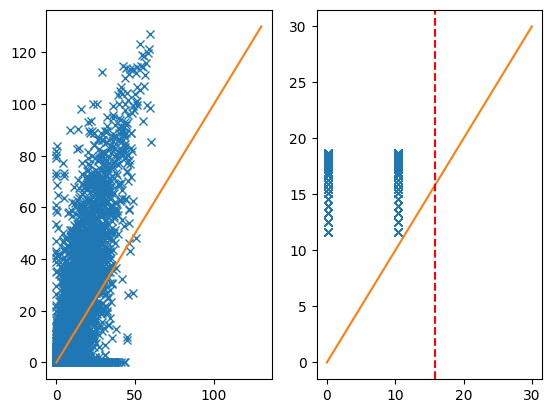

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.683  0.256E+00    31968    61.11  0.239   [Radiance 1.240 micron]
     1  -0.655  0.263E+00    31968    61.11  0.239   [Radiance 2.130 micron]
     1  -0.684  0.234E+00    31968    61.11  0.239   [Radiance 0.660 micron]
     1  -0.670  0.264E+00    31968    61.11  0.239   [Radiance 1.640 micron]
     2  -1.220  0.277E+00    31968    61.11  0.239   [Radiance 1.240 micron]
     2  -1.082  0.299E+00    31968    61.11  0.239   [Radiance 2.130 micron]
     2  -1.231  0.250E+00    31968    61.11  0.239   [Radiance 0.660 micron]
     2  -1.151  0.290E+00    31968    61.11  0.239   [Radiance 1.640 micron]
     3  -1.628  0.276E+00    31968    61.11  0.239   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

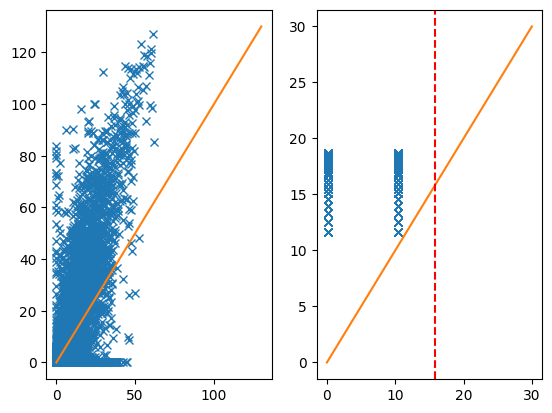

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.680  0.259E+00    31968    61.23  0.239   [Radiance 1.240 micron]
     1  -0.681  0.240E+00    31968    61.23  0.239   [Radiance 0.660 micron]
     1  -0.649  0.266E+00    31968    61.23  0.239   [Radiance 2.130 micron]
     1  -0.666  0.262E+00    31968    61.23  0.239   [Radiance 1.640 micron]
     2  -1.218  0.285E+00    31968    61.23  0.239   [Radiance 1.240 micron]
     2  -1.078  0.296E+00    31968    61.23  0.239   [Radiance 2.130 micron]
     2  -1.148  0.294E+00    31968    61.23  0.239   [Radiance 1.640 micron]
     2  -1.230  0.260E+00    31968    61.23  0.239   [Radiance 0.660 micron]
     3  -1.629  0.285E+00    31968    61.23  0.239   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

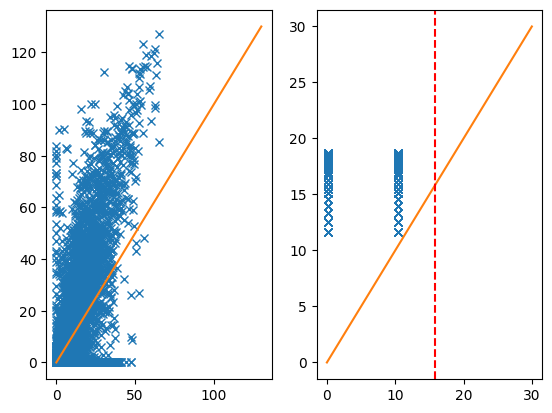

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.683  0.264E+00    31968    59.21  0.231   [Radiance 0.660 micron]
     1  -0.682  0.280E+00    31968    59.21  0.231   [Radiance 1.240 micron]
     1  -0.647  0.287E+00    31968    59.21  0.231   [Radiance 2.130 micron]
     1  -0.667  0.279E+00    31968    59.21  0.231   [Radiance 1.640 micron]
     2  -1.235  0.290E+00    31968    59.21  0.231   [Radiance 0.660 micron]
     2  -1.223  0.312E+00    31968    59.21  0.231   [Radiance 1.240 micron]
     2  -1.151  0.316E+00    31968    59.21  0.231   [Radiance 1.640 micron]
     2  -1.078  0.323E+00    31968    59.21  0.231   [Radiance 2.130 micron]
     3  -1.665  0.291E+00    31968    59.21  0.231   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

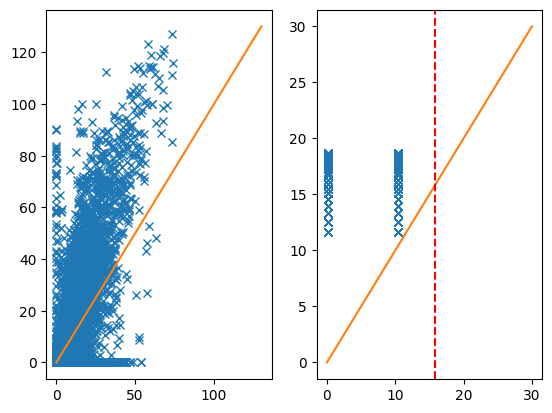

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.683  0.286E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     1  -0.668  0.297E+00    31968    59.04  0.231   [Radiance 1.640 micron]
     1  -0.650  0.302E+00    31968    59.04  0.231   [Radiance 2.130 micron]
     1  -0.683  0.301E+00    31968    59.04  0.231   [Radiance 1.240 micron]
     2  -1.238  0.315E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     2  -1.154  0.339E+00    31968    59.04  0.231   [Radiance 1.640 micron]
     2  -1.226  0.337E+00    31968    59.04  0.231   [Radiance 1.240 micron]
     2  -1.081  0.336E+00    31968    59.04  0.231   [Radiance 2.130 micron]
     3  -1.665  0.318E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

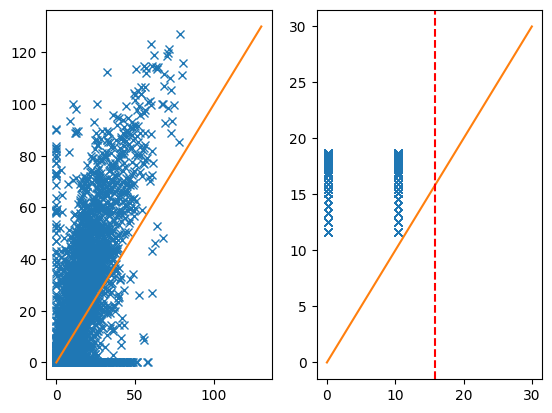


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7935      5      6   1032     0  1225   1.112D+00   1.438D+04
  F =   14382.963428233837     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.683  0.286E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     1  -0.683  0.301E+00    31968    59.04  0.231


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
     1  -0.683  0.301E+00    31968    59.04  0.231   [Radiance 1.240 micron]
     1  -0.683  0.286E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     1  -0.650  0.302E+00    31968    59.04  0.231   [Radiance 2.130 micron]
     1  -0.668  0.297E+00    31968    59.04  0.231   [Radiance 1.640 micron]
     2  -1.238  0.315E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     2  -1.226  0.337E+00    31968    59.04  0.231   [Radiance 1.240 micron]
     2  -1.154  0.339E+00    31968    59.04  0.231   [Radiance 1.640 micron]
     2  -1.081  0.336E+00    31968    59.04  0.231   [Radiance 2.130 micron]
     3  -1.665  0.318E+00    31968    59.04  0.231   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

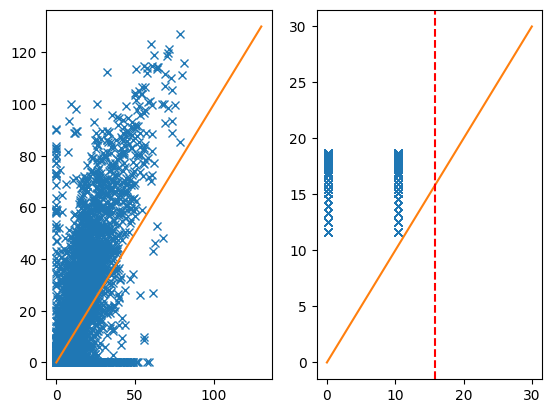

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.687  0.304E+00    31968    57.42  0.224   [Radiance 0.660 micron]
     1  -0.686  0.322E+00    31968    57.42  0.224   [Radiance 1.240 micron]
     1  -0.656  0.304E+00    31968    57.42  0.224   [Radiance 2.130 micron]
     1  -0.673  0.318E+00    31968    57.42  0.224   [Radiance 1.640 micron]
     2  -1.243  0.333E+00    31968    57.42  0.224   [Radiance 0.660 micron]
     2  -1.083  0.350E+00    31968    57.42  0.224   [Radiance 2.130 micron]
     2  -1.158  0.361E+00    31968    57.42  0.224   [Radiance 1.640 micron]
     2  -1.232  0.357E+00    31968    57.42  0.224   [Radiance 1.240 micron]
     3  -1.664  0.337E+00    31968    57.42  0.224   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

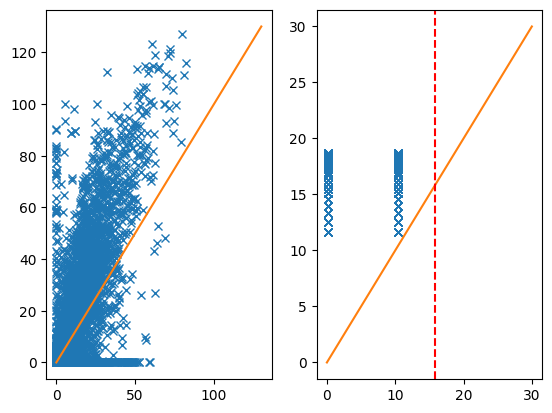

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.684  0.331E+00    31968    57.91  0.226   [Radiance 0.660 micron]
     1  -0.683  0.353E+00    31968    57.91  0.226   [Radiance 1.240 micron]
     1  -0.649  0.332E+00    31968    57.91  0.226   [Radiance 2.130 micron]
     1  -0.668  0.351E+00    31968    57.91  0.226   [Radiance 1.640 micron]
     2  -1.230  0.389E+00    31968    57.91  0.226   [Radiance 1.240 micron]
     2  -1.242  0.361E+00    31968    57.91  0.226   [Radiance 0.660 micron]
     2  -1.079  0.386E+00    31968    57.91  0.226   [Radiance 2.130 micron]
     2  -1.155  0.394E+00    31968    57.91  0.226   [Radiance 1.640 micron]
     3  -1.626  0.397E+00    31968    57.91  0.226   [Radiance 1.240 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

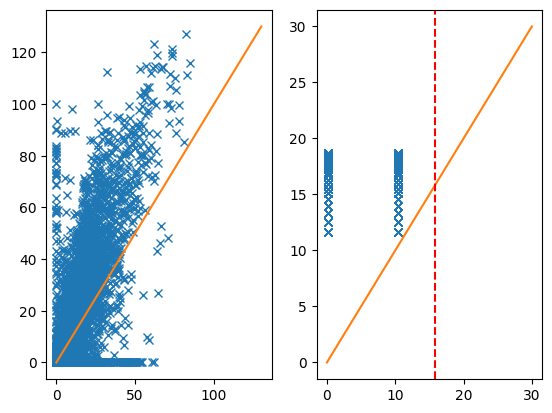

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.681  0.348E+00    31968    61.10  0.239   [Radiance 0.660 micron]
     1  -0.666  0.371E+00    31968    61.10  0.239   [Radiance 1.640 micron]
     1  -0.681  0.372E+00    31968    61.10  0.239   [Radiance 1.240 micron]
     1  -0.650  0.353E+00    31968    61.10  0.239   [Radiance 2.130 micron]
     2  -1.239  0.379E+00    31968    61.10  0.239   [Radiance 0.660 micron]
     2  -1.155  0.415E+00    31968    61.10  0.239   [Radiance 1.640 micron]
     2  -1.228  0.408E+00    31968    61.10  0.239   [Radiance 1.240 micron]
     2  -1.083  0.408E+00    31968    61.10  0.239   [Radiance 2.130 micron]
     3  -1.654  0.384E+00    31968    61.10  0.239   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

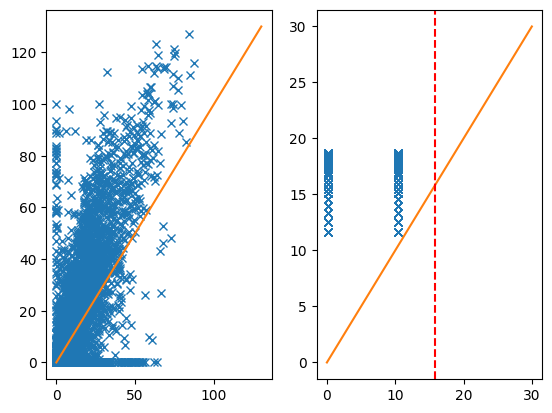

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.684  0.359E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     1  -0.684  0.383E+00    31968    61.15  0.239   [Radiance 1.240 micron]
     1  -0.670  0.382E+00    31968    61.15  0.239   [Radiance 1.640 micron]
     1  -0.656  0.365E+00    31968    61.15  0.239   [Radiance 2.130 micron]
     2  -1.242  0.390E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     2  -1.159  0.427E+00    31968    61.15  0.239   [Radiance 1.640 micron]
     2  -1.232  0.420E+00    31968    61.15  0.239   [Radiance 1.240 micron]
     2  -1.088  0.420E+00    31968    61.15  0.239   [Radiance 2.130 micron]
     3  -1.654  0.396E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     3  -1.

<Figure size 640x480 with 0 Axes>

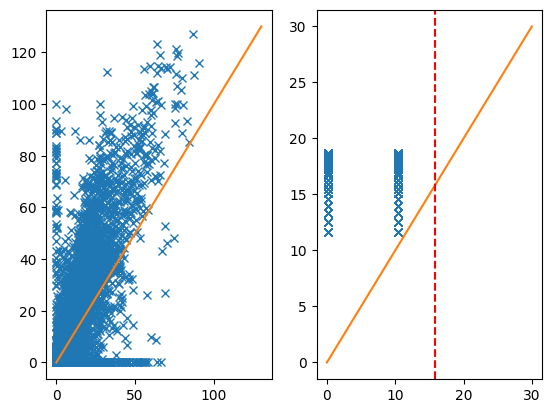


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7935      5      6    925     0   929   1.120D+00   1.161D+04
  F =   11605.331333075850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
     1  -0.684  0.383E+00    31968    61.15  0.239   [Radiance 1.240 micron]
     1  -0.684  0.359E+00    31968    61.15  0.239


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [9]:
saved = []
for i in range (3):
    train_density(data["density"].data)
    train_reff(solvers_reconstruct[0.66].medium['cloud'].reff.data)
    saved.append(solvers_reconstruct.copy())
    print("-------Saved " + str(i) + "--------")

In [10]:
train_reff(solvers_reconstruct[0.66].medium['cloud'].reff.data)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.240 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.684  0.359E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     1  -0.684  0.383E+00    31968    61.15  0.239   [Radiance 1.240 micron]
     1  -0.670  0.382E+00    31968    61.15  0.239   [Radiance 1.640 micron]
     1  -0.656  0.365E+00    31968    61.15  0.239   [Radiance 2.130 micron]
     2  -1.242  0.390E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     2  -1.232  0.420E+00    31968    61.15  0.239   [Radiance 1.240 micron]
     2  -1.159  0.427E+00    31968    61.15  0.239   [Radiance 1.640 micron]
     2  -1.088  0.420E+00    31968    61.15  0.239   [Radiance 2.130 micron]
     3  -1.654  0.396E+00    31968    61.15  0.239   [Radiance 0.660 micron]
     3  -1.


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
